In [1]:
# lib
# ! pip install albumentations

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
# change shape without num_elements changing

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# load
class CamVidDataset(torch.utils.data.Dataset):
    """
    CamVid Dataset: read images, augmentation and preprocessing transformation
    args:
        images_dir(str): path to images folder
        masks_dir(str): path to segmentation masks folder
        class_values(list): values of classees to exract from segmentation mask
        augmentation(albumentations.Compose): data transformation pipeline(flip, scale)
        preprocessing(albumentations.Compose): data preprocessing(noralization, shape manipulation)
    """
    def __init__(self, images_dir, masks_dir):
        self.transform = A.Compose([
            A.Resize(256, 256),
            # A.HorizontalFlip(),  # x-axis
            # A.VerticalFlip(),  # y-axis
            A.Normalize(),  # normalization: ?range(0-256)
            ToTensorV2(),
        ])
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, mask_id.split('.')[0]+'_L'+'.png') for mask_id in self.ids]
        
    def __getitem__(self, i):
        # read data
        image = np.array(Image.open(self.images_fps[i]).convert('RGB'))
        mask = np.array(Image.open(self.masks_fps[i]).convert('RGB'))
        image = self.transform(image=image, mask=mask)
        return image['image'], image['mask'][:,:,0]
    
    def __len__(self):
        return len(self.ids)

x_train_dir = os.path.join('/kaggle/input/camvid/CamVid/train')
y_train_dir = os.path.join('/kaggle/input/camvid/CamVid/train_labels')
x_valid_dir = os.path.join('/kaggle/input/camvid/CamVid/val')
y_valid_dir = os.path.join('/kaggle/input/camvid/CamVid/val_labels')

train_dataset = CamVidDataset(x_train_dir, y_train_dir)
valid_dataset = CamVidDataset(x_valid_dir, y_valid_dir)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=True)
# (org)image_size: torch.Size([batchsize, 3, 720, 960]), mask_size: torch.Size([batchsize, 720, 960])

In [3]:
# Net: out:nn.Sigmoid()

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResBlock, self).__init__()
        # block: encoding2,3, bridge
        self.res = nn.Sequential(
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, out_ch, 3, stride, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
        )
        # block: enconding1
        self.rs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
        )
        self.cx = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 1, stride, 0),
        )
    def forward(self, x, conv_bt=True):
        if conv_bt:
            out = self.res(x)
        else:
            out = self.rs(x)
        # addition: change the channel_num(resolution), with 1x1kernel
        x = self.cx(x)
        out += x
        return out
    
class ResUnet(nn.Module):
    def __init__(self):
        super(ResUnet, self).__init__()
        # channel = [3, 64, 128, 256, 512]
        # encoding
        self.e1 = ResBlock(3, 64)     # channel[0], channel[1]
        self.e2 = ResBlock(64, 128, stride=2)   # channel[1], channel[2]
        self.e3 = ResBlock(128, 256, stride=2)  # channel[2], channel[3]
        # bridge
        self.b0 = ResBlock(256, 512, stride=2)  # channel[3], channel[4]
        # decoding
        self.d1 = ResBlock(768, 256)  # channel[4]+channel[3], channel[3]
        self.d2 = ResBlock(384, 128)  # channel[3]+channel[2], channel[2]
        self.d3 = ResBlock(192, 64)   # channel[2]+channel[1], channel[1]
        
        self.us = nn.Upsample(scale_factor=2, mode='bilinear')
        self.so = nn.Sequential(
            nn.Conv2d(64, 1, 1, 1, 0),
            nn.Sigmoid(),
        )
    def forward(self, x):
        out1 = self.e1(x, conv_bt=False)
        out2 = self.e2(out1)
        out3 = self.e3(out2)
        out = self.us(self.b0(out3))
        out = self.us(self.d1(torch.cat([out, out3], dim=1)))
        out = self.us(self.d2(torch.cat([out, out2], dim=1)))
        out = self.d3(torch.cat([out, out1], dim=1))
        out = self.so(out)
        return out

In [4]:
# loss
class DiceBCELoss(nn.Module):
    # without loss descend
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        # BCEWithLogitsLoss: sigmoid+BCELoss
        self.dgrad = nn.BCELoss()
        
    def forward(self, inputs, targets, smooth=1):
        targets = torch.sigmoid(targets)
        # flatten label and prediction
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        # print(targets)
        intersection = (inputs*targets).sum()
        union = inputs.sum() + (targets.sum())
        dice_loss = 1 - ((2*intersection+smooth)/(union+smooth))
        bce_loss = self.dgrad(inputs, targets)
        loss = dice_loss + bce_loss
        return loss

class IoU(nn.Module):
    def __init__(self):
        super(IoU, self).__init__()
        
    def forward(self, inputs, targets, smooth=0.1, threshold=256*0.3):
        # flatten label and prediction
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        tempinputs = inputs.detach().cpu()
        temptargets = targets.detach().cpu()
        
        temptargets[np.nonzero(temptargets<threshold)] = 0.0
        temptargets[np.nonzero(temptargets>=threshold)] = 1.0
        # print(tempinputs, temptargets)
        intersection = (tempinputs*temptargets).sum()
        union = tempinputs.sum() + temptargets.sum()
        iou = (intersection+smooth)/(union-intersection+smooth)
        # print(intersection, union, iou)
        return iou

In [5]:
# train, test
def trainer(model, train_loader, valid_loader,
            criterion, optimizer, iou, epochs):
    
    loss_hist, train_hist, valid_hist = [],[],[]
    patience, best_acc, stale = 11, 0, 0
    for epoch in range(epochs):
        print('epoch{}/{}'.format(epoch+1, epochs))
        model.train()
        losses, train_iou, valid_iou = [],[],[]
        for image, mask in train_loader:
            image = image.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            pred = model.forward(image)
            
            trainpiou = iou(pred,mask)
            loss = criterion(pred, mask)
            
            losses.append(loss.item())
            train_iou.append(trainpiou.detach().cpu())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            for image, mask in valid_loader:
                image = image.to(device)
                mask = mask.to(device)
                pred = model.forward(image)
                validpiou = iou(pred, mask)
            valid_iou.append(validpiou.detach().cpu())
        
        loss_hist.append(np.mean(losses))
        train_hist.append(np.mean(train_iou))
        valid_hist.append(np.mean(valid_iou))
        print('loss:{}'.format(loss_hist[-1]))
        print('Train Accuracy:{}'.format(train_hist[-1]))
        print('Validation Accuracy:{}'.format(valid_hist[-1]))
        
        if valid_hist[-1] > best_acc:
            print(f'Best model found at epoch {epoch+1}, saving model')
            torch.save(model.state_dict(), 'segbrain_unetpp.pt')
            best_acc = valid_hist[-1]
            stale = 0
        else:
            stale += 1
            if stale > patience:
                print(f'No improvment {patience} consecutive epochs, break.')
                break
            
    return loss_hist, train_hist, valid_hist


def plot_model_hist(train_hist, valid_hist, loss_hist):
    x = np.arange(len(train_hist))
    
    fig = plt.figure(figsize=(10,6))
    plt.plot(x, train_hist, label='train_dice')
    plt.plot(x, valid_hist, label='valid_dice')
    plt.plot(x, loss_hist, label='train_loss')
    
    plt.title('ResUnet', fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('Dice/Loss')
    
    plt.show()

epoch1/17
loss:0.24275616113398527
Train Accuracy:0.7993658185005188
Validation Accuracy:0.7896604537963867
Best model found at epoch 1, saving model
epoch2/17
loss:0.19814568707669103
Train Accuracy:0.8167591094970703
Validation Accuracy:0.8057076334953308
Best model found at epoch 2, saving model
epoch3/17
loss:0.18354297409186493
Train Accuracy:0.8249565362930298
Validation Accuracy:0.8020744323730469
epoch4/17
loss:0.17743631774509275
Train Accuracy:0.8282135128974915
Validation Accuracy:0.8356664180755615
Best model found at epoch 4, saving model
epoch5/17
loss:0.16850125407044952
Train Accuracy:0.8326781392097473
Validation Accuracy:0.8251934051513672
epoch6/17
loss:0.16454114392399788
Train Accuracy:0.8345123529434204
Validation Accuracy:0.8526598215103149
Best model found at epoch 6, saving model
epoch7/17
loss:0.1612376882820516
Train Accuracy:0.8362433910369873
Validation Accuracy:0.8440384268760681
epoch8/17
loss:0.15859003979209307
Train Accuracy:0.8375604748725891
Validati

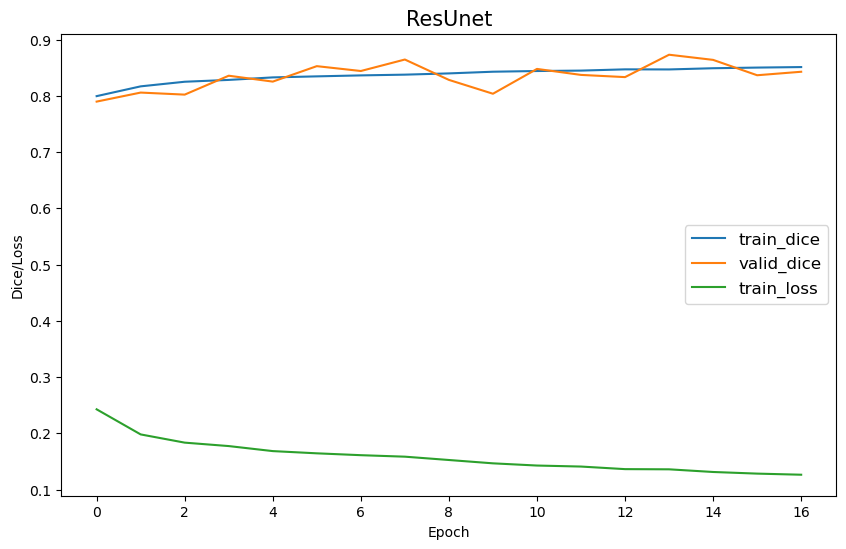

In [6]:
# run
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResUnet().to(device)
criterion = DiceBCELoss()
iou = IoU()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 17

loss_hist, train_hist, valid_hist = trainer(model, train_loader, valid_loader, criterion, optimizer, iou,epochs)
plot_model_hist(train_hist, valid_hist, loss_hist)